#Analyzing Social Networks

The networks discussed in this recitation are **“egocentric” networks**. 

- The term **“ego”** is used to denote a person connected to everyone in the network. 
- An ego network is the social world from **ego**'s point of view. 
- It is convention to use the term **“alter”** to refer to anyone else in the network. 
- This way, one can talk about both friends and followers or fans; it does not matter what role they play: from **ego's perspective**, they are all alters.

The data used in this recitation is from https://snap.stanford.edu/data/ego-Facebook.html. The data file facebook_combined.txt is already included in the zip folder which contains this notebook.



In [49]:
import pandas as pd    # for reading and manipulating tabular data
import networkx as nx  # for constructing and studying networks
import numpy as np     # for arrays
#import community           # for community structure later
import collections          # for manipulation tuples and zipping objects
import statistics as stats  # for generating summary statistics
import time                 # for measuring computating time
from matplotlib import pyplot as plt  # for outputting nice plots
import seaborn as sns                 # for creating even nicer plots
import urllib
import gzip
get_ipython().magic(u'matplotlib inline')

In [50]:
data_url="https://snap.stanford.edu/data/facebook_combined.txt.gz"
facebook_data_file_compressed = urllib.request.urlopen(data_url)
facebook_data_file=gzip.open(facebook_data_file_compressed ,'rt')

In [51]:
# Create graph from edge list stored in data file
G = nx.read_edgelist(facebook_data_file,
                     create_using = nx.Graph(), # Use Graph() instead of DiGraph() for directed vs. undirected, 
                     nodetype = int) # Do not forget to specify node information type

## Exploratory Analysis

In [52]:
print(nx.info(G))

Graph with 4039 nodes and 88234 edges


In [53]:
G_nodes_list = list(G.nodes())
print(G_nodes_list[:5])

[0, 1, 2, 3, 4]


In [54]:
G_edges_list = list(G.edges())
print(G_edges_list[:5])

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]


### Empirical Degree Distribution

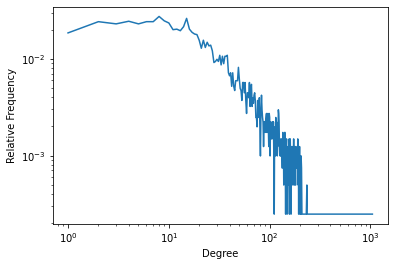

In [55]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
deg, counts = np.unique(degree_sequence, return_counts=True)

plt.plot(deg, counts/sum(counts))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Degree")
plt.ylabel("Relative Frequency")

plt.show()

### Visualization
Look at [this resource](https://networkx.org/documentation/stable/reference/drawing.html#module-networkx.drawing.layout) to find more options for visualizing the graph. 
Find one you prefer that emphasizes the separate communities. 

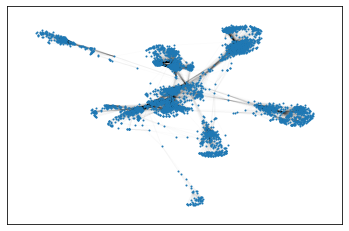

In [61]:
#Visualize the graph
pos = nx.spring_layout(G) # Replace this line to generate a more intuitive visualization 
# Options: nx.circular_layout; nx.spectral_layout; nx.spring_layout;
nx.draw_networkx_nodes(G, pos,  node_size=1)
nx.draw_networkx_edges(G, pos, alpha=0.01)
plt.show()

## Analysis

**What global characteristics of the graph would be easy to compute using networkx Python package?**

These concepts should normally be a review from the lecture!

- **Diameter** of the network (i.e., what is the maximum distance between any two nodes?)

*Note: it only makes sense to talk about the diameter of a network if every node is connected, otherwise it will be infinity.*

- **Density** of the graph (i.e., how many edges do we observe in the network, as compared to the total number of possible connections?)

- **Clustering coefficient** of the network (i.e., measure of the degree to which nodes in a graph tend to cluster together)

- **Centrality Measures** of each node of the newtork (e.g. degree centrality, betweeness centrality, etc.)

In [ ]:
def graph_characteristics(graph):
    t = time.time()
    graph_diameter = nx.diameter(graph)
    elapsed = time.time() - t
    print('Time elapsed to get the diameter: ', elapsed)
    
    t = time.time()
    graph_density = nx.density(graph)
    elapsed = time.time() - t
    print('Time elapsed to get the density: ', elapsed)
    
    t = time.time()
    graph_triangles = len(nx.triangles(graph))
    elapsed = time.time() - t
    print('Time elapsed to get the number of triangles: ', elapsed)
    
    t = time.time()
    graph_transitivity = nx.transitivity(graph)
    elapsed = time.time() - t
    print('Time elapsed to get the transitivity: ', elapsed)
    
    t = time.time()
    graph_avg_clustering = nx.average_clustering(graph)
    elapsed = time.time() - t
    print('Time elapsed to get the average clustering coefficient: ', elapsed)
    
    print("Here is a quick overview of the graph profile: diameter = " + '{:.4f}'.format(graph_diameter) + ", density = " + '{:.4f}'.format(graph_density) + ",\nnumber of triangles = " + '{:d}'.format(graph_triangles) + ", transitivity = " + '{:.4f}'.format(graph_transitivity) + ", average clustering coefficient = " + '{:.4f}'.format(graph_avg_clustering))
    
    return()
graph_characteristics(G)

Time elapsed to get the diameter:  67.39796686172485
Time elapsed to get the density:  0.002687215805053711
Time elapsed to get the number of triangles:  2.7501065731048584
Time elapsed to get the transitivity:  2.7649359703063965
Time elapsed to get the average clustering coefficient:  2.758829355239868
Here is a quick overview of the graph profile: diameter = 8.0000, density = 0.0108,
number of triangles = 4039, transitivity = 0.5192, average clustering coefficient = 0.6055


()

## Community Structure 

The classical **modularity** of a partition $c:\mathcal{N} \rightarrow [N]$ is defined to be 

$$
Q \triangleq \frac{1}{2m} \sum_{u,v \in \mathcal{N}} \big( A_{uv} - \frac{k_u k_v}{2m} \big) \delta(c(u), c(v))\;.
$$

Intuitively, the modularity measures how many edges are observed *within* communities and compares that to a configuration null-model. High values of the modularity imply that there are many more edges within communities than would be expected. Many community-detection algorithms seek partitions that maximize $Q$. 

The method below uses the [*Louvain algorithm*](https://en.wikipedia.org/wiki/Louvain_Modularity) to calculate community partitions with high modularity. 

In [58]:
!pip install python_louvain
from community import community_louvain

In [59]:
partition = community_louvain.best_partition(G)
communities = [partition.get(node) for node in G.nodes()]
print('The number of communities is ' + str(max(communities)) + '.')

# Let's assign each node to its given community
nx.set_node_attributes(G, partition, name='community')

The number of communities is 15.


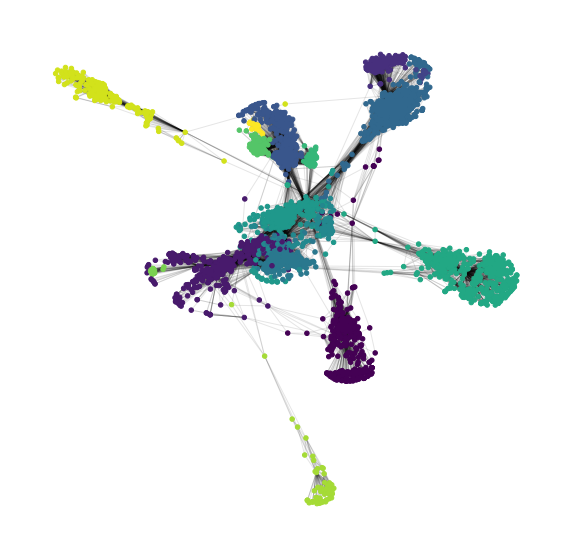

In [62]:
colors = [G.nodes()[node]['community'] for node in G.nodes()]

fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111)
ax.axis('off')

nx.draw_networkx_nodes(G, pos,  node_size=20, node_color = communities)
nx.draw_networkx_edges(G, pos, alpha=0.1)
plt.show()

In [ ]:
dendro = community_louvain.generate_dendrogram(G)
for level in range(len(dendro) - 1) :
  partition =  community_louvain.partition_at_level(dendro, level)
  num_clusters = len(np.unique(list(partition.values())))
  print(num_clusters)
  mod = community_louvain.modularity(partition, G)
  print('Modularity with {} clusters: {}'.format(num_clusters, mod))

100
Modularity with 100 clusters: 0.8121193041288923
17
Modularity with 17 clusters: 0.8337578286854019


In [ ]:
np.unique(list(dendro[0].values()))

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102])